Original class distribution: Counter({0: 784535, 1: 4467, 5: 2466, 2: 1093})
Train: Counter({0: 35740, 1: 35740, 2: 35740, 5: 35740}) | Test: Counter({0: 219, 1: 219, 2: 219, 5: 219})
Epoch 1/20, Loss: 0.9986
Epoch 2/20, Loss: 0.8923
Epoch 3/20, Loss: 0.6189
Epoch 4/20, Loss: 0.5724
Epoch 5/20, Loss: 0.3900
Epoch 6/20, Loss: 0.2956
Epoch 7/20, Loss: 0.2396
Epoch 8/20, Loss: 0.2079
Epoch 9/20, Loss: 0.1734
Epoch 10/20, Loss: 0.1582
Epoch 11/20, Loss: 0.1413
Epoch 12/20, Loss: 0.1251
Epoch 13/20, Loss: 0.1198
Epoch 14/20, Loss: 0.1094
Epoch 15/20, Loss: 0.1062
Epoch 16/20, Loss: 0.0947
Epoch 17/20, Loss: 0.0912
Epoch 18/20, Loss: 0.0867
Epoch 19/20, Loss: 0.0815
Epoch 20/20, Loss: 0.0757
Classification Report (Balanced Test Set - LSTM):
              precision    recall  f1-score   support

           F       0.80      0.98      0.88       219
           N       0.96      0.97      0.96       219
           S       0.95      0.77      0.85       219
           V       0.96      0.93     

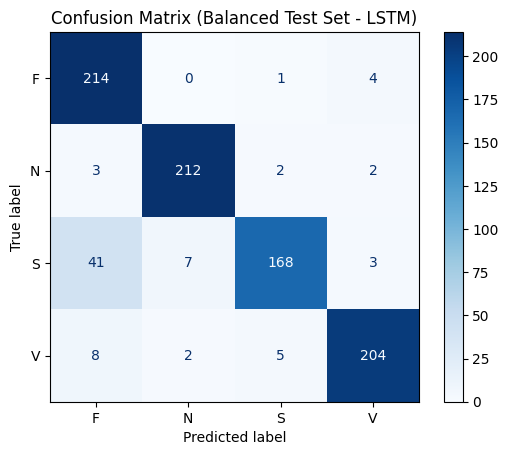

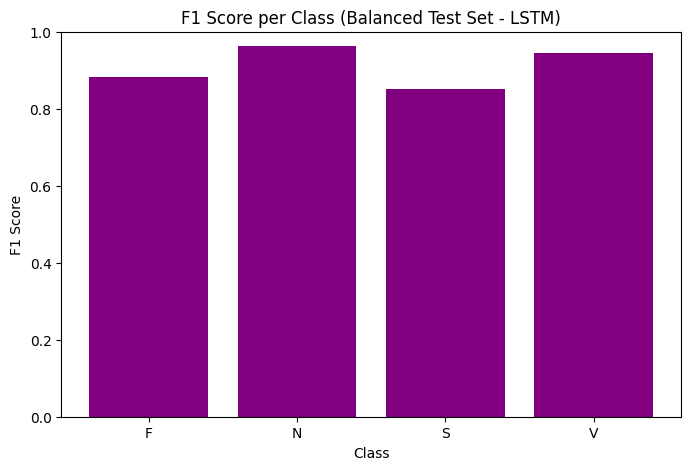

In [2]:
# ✅ Import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

# ✅ Load data
X = np.load("C:/Users/arfao/Desktop/stage_2025/processed_multiclass_filtered500/X_segments.npy")
y = np.load("C:/Users/arfao/Desktop/stage_2025/processed_multiclass_filtered500/y_labels.npy")
print(f"Original class distribution: {Counter(y)}")

# ✅ Flatten + scale
X_flat = X.reshape((X.shape[0], -1))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# ✅ Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# ✅ SMOTE + undersample
minority_classes = [cls for cls in Counter(y_train) if cls != Counter(y_train).most_common(1)[0][0]]
largest_minority_count = max([Counter(y_train)[cls] for cls in minority_classes])
target_count = largest_minority_count * 10

smote_strategy = {cls: target_count for cls in Counter(y_train) if cls != Counter(y_train).most_common(1)[0][0]}
sm = SMOTE(random_state=42, sampling_strategy=smote_strategy)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

rus = RandomUnderSampler(sampling_strategy={cls: target_count for cls in Counter(y_train_res)}, random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(X_train_res, y_train_res)

rus_test = RandomUnderSampler(
    sampling_strategy={cls: min(Counter(y_test).values()) for cls in np.unique(y_test)}, random_state=42)
X_test_bal, y_test_bal = rus_test.fit_resample(X_test, y_test)

print(f"Train: {Counter(y_train_bal)} | Test: {Counter(y_test_bal)}")

# ✅ Remap labels to 0..3
label_map = {0: 0, 1: 1, 2: 2, 5: 3}
y_train_bal = np.array([label_map[label] for label in y_train_bal])
y_test_bal = np.array([label_map[label] for label in y_test_bal])

class_names = ['F', 'N', 'S', 'V']

# ✅ Reshape for LSTM
time_steps = X.shape[1]
X_train_lstm = X_train_bal.reshape((-1, time_steps, 1)).astype(np.float32)
X_test_lstm = X_test_bal.reshape((-1, time_steps, 1)).astype(np.float32)

# ✅ Convert to tensors
X_train_tensor = torch.tensor(X_train_lstm)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_lstm)
y_test_tensor = torch.tensor(y_test_bal, dtype=torch.long)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# ✅ Define model
class ECG_LSTM(nn.Module):
    def __init__(self, num_classes):
        super(ECG_LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

num_classes = len(class_names)
model = ECG_LSTM(num_classes)

# ✅ Loss + optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# ✅ Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# ✅ Map to class names
y_test_named = [class_names[i] for i in all_labels]
y_pred_named = [class_names[i] for i in all_preds]

# ✅ Report + Confusion matrix
print("Classification Report (Balanced Test Set - LSTM):")
print(classification_report(y_test_named, y_pred_named, labels=class_names))

cm = confusion_matrix(y_test_named, y_pred_named, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Balanced Test Set - LSTM)")
plt.show()

f1_per_class = f1_score(y_test_named, y_pred_named, labels=class_names, average=None)
plt.figure(figsize=(8, 5))
plt.bar(class_names, f1_per_class, color='purple')
plt.title('F1 Score per Class (Balanced Test Set - LSTM)')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()
